# Summary

```Objective```

Inject Rotation, Translation, Artifact, and Deformation to images.

```Methods```

Use the function in torchio.RandomAffine, torchio.RandomMotion, torchio.RandomElasticDeformation

```Results```

todo

# Config

# Libs

In [1]:
import numpy as np
import torch
import torchio as tio
import torchio.transforms as transforms
import matplotlib.pyplot as plt
import h5py
import math
from scipy.fft import fftn, ifftn, fftshift, ifftshift
from misalign.data.IXI_datamodule import IXIDataModule
from misalign.draw import blend_and_transpose

def show_img(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.show()

c:\Users\NUGURI\anaconda3\envs\misalign\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Analysis

### 1. Load Raw data

In [2]:
def show_img(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=0.6)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
dataroot = 'C:/Users/NUGURI/Workspace/misalign-benchmark/data/IXI/test/data.mat'
mat = h5py.File(dataroot, 'r')
print(mat.keys())

raw_T1 = np.array(mat['data_x'])
raw_T1 = raw_T1[:,:,:,1].squeeze()
raw_T2 = np.array(mat['data_y'])
raw_T2 = raw_T2[:,:,:,1].squeeze()
print('T1 size:', raw_T1.shape)
print('T2 size:', raw_T2.shape)
mat.close()

<KeysViewHDF5 ['data_x', 'data_y']>
T1 size: (256, 256, 910)
T2 size: (256, 256, 910)


### 2. Random Affine (z-Rotation, y-Translation)

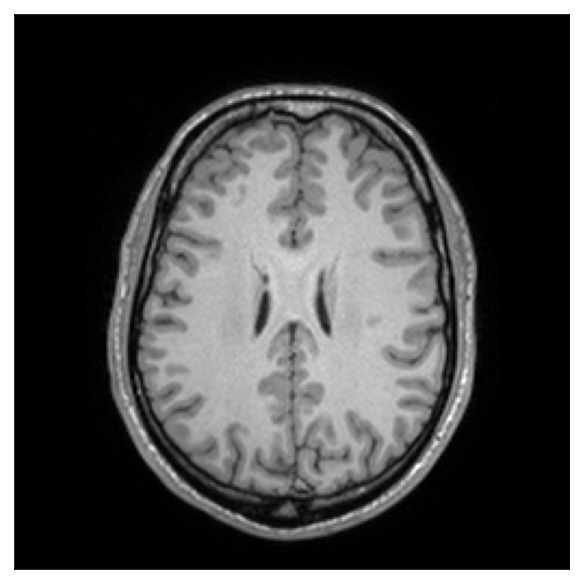

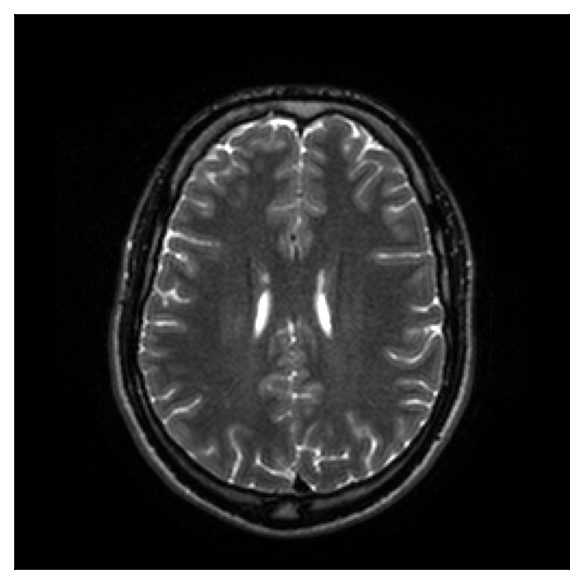

In [27]:
torch.manual_seed(123)

s_transform = tio.RandomAffine(
    scales =0,
    degrees=(0,0,0,0,0,0),  # z-axis 2D-Rotation range in degrees. (0,0,0,0,-5,-5)
    translation=(0,0,0,0,0,0),  # (0,0,-5,-5,0,0)
    default_pad_value = 'otsu',  # edge control, fill value is the mean of the values at the border that lie under an Otsu threshold.
)

t_transform = tio.RandomAffine(
    scales =0,
    degrees=(0,0,0,0,0,0),  # z-axis 2D-Rotation range in degrees. (0,0,0,0,5,5)
    translation=(0,0,0,0,0,0),  # (0,0,5,5,0,0)
    default_pad_value = 'otsu',  # edge control, fill value is the mean of the values at the border that lie under an Otsu threshold.
)

tmp_T1 = np.expand_dims(raw_T1, axis=0)
tmp_T2 = np.expand_dims(raw_T2, axis=0)
transformed_T1 = np.array(s_transform(tmp_T1).squeeze())
transformed_T2 = np.array(t_transform(tmp_T2).squeeze())

zz = 57

blended_image = np.zeros((256, 256, 3))
blended_image[:, :, 0] = transformed_T1[:,:,zz]*0.7
blended_image[:, :, 1] = transformed_T1[:,:,zz]*0.3
blended_image[:, :, 2] = transformed_T2[:,:,zz]

# show_img(np.concatenate((transformed_T1[:,:,zz], transformed_T2[:,:,zz]),0))
# show_img(blended_image)

show_img(transformed_T1[:,:,zz])
show_img(transformed_T2[:,:,zz])

### 3. Random 3D-Motion Artifact

In [ ]:
# torch.manual_seed(121)
# Define the 3D-RandomMotion transform
random_motion = tio.RandomMotion(
    degrees=2.5,  # Maximum rotation angle in degrees
    translation=5,  # Maximum translation in mm
    num_transforms=3  # Number of motion transformations to apply
)

tmp1 = np.expand_dims(raw_T1, axis=0)
tmp2 = np.expand_dims(raw_T2, axis=0)

Motion_T1_v1 = random_motion(tmp1).squeeze()
Motion_T2_v1 = random_motion(tmp2).squeeze()

zz = 50
# show_img(np.concatenate((raw_T1[:,:,zz], Motion_T1_v1[:,:,zz]),0))
# show_img(np.concatenate((raw_T2[:,:,zz], Motion_T2_v1[:,:,zz]),0))

residual = np.zeros((256, 256))
residual = abs(raw_T2 - Motion_T2_v1)

show_img(np.concatenate((raw_T2[:,:,zz], Motion_T2_v1[:,:,zz], residual[:,:,zz]),0))

In [10]:
def JHL_prob(raw_img, motion_img, prob):
    assert (
        prob >= 0
    ), "prob must have zero or positive value"

    raw_k = fftshift(fftn(raw_img))
    motion_k = fftshift(fftn(motion_img))
    diff = math.ceil(2.56*prob)

    raw_k[:,128-diff : 128,:] = motion_k[:,128-diff : 128,:]

    res = abs(ifftn(ifftshift(raw_k)))
    return res

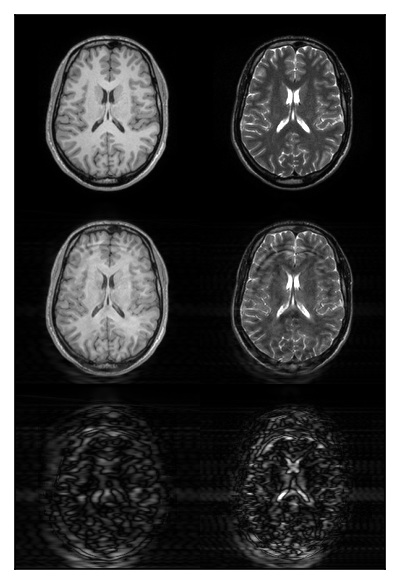

In [14]:
# torch.manual_seed(121)
# Define the 3D-RandomMotion transform
random_motion = tio.RandomMotion(
    degrees=(5,5),              # Maximum rotation angle in degrees
    translation=(10,10),         # Maximum translation in mm
    num_transforms=10       # Number of motion transformations to apply
)

tmp1 = np.expand_dims(raw_T1, axis=0)
tmp2 = np.expand_dims(raw_T2, axis=0)

Motion_T1 = random_motion(tmp1).squeeze()
Motion_T2 = random_motion(tmp2).squeeze()

Motion_T1_prob = JHL_prob(raw_T1, Motion_T1, prob=6)  # prob=6
Motion_T2_prob = JHL_prob(raw_T2, Motion_T2, prob=6)  # prob=6

zz = 50
residual_T1 = np.zeros((256, 256, 910))
residual_T1 = abs(raw_T1 - Motion_T1_prob)

residual_T2 = np.zeros((256, 256, 910))
residual_T2 = abs(raw_T2 - Motion_T2_prob)

# show_img(np.concatenate((raw_T1[:,:,zz], Motion_T1_prob[:,:,zz], 3*residual_T1[:,:,zz]),0))
# show_img(np.concatenate((raw_T2[:,:,zz], Motion_T2_prob[:,:,zz], 3*residual_T2[:,:,zz]),0))

show_img(np.concatenate( (np.concatenate((raw_T1[:,:,zz], Motion_T1_prob[:,:,zz], 3*residual_T1[:,:,zz]),0), np.concatenate((raw_T2[:,:,zz], Motion_T2_prob[:,:,zz], 3*residual_T2[:,:,zz]),0)) ,1))

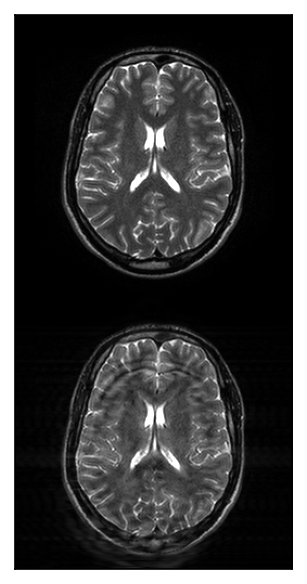

In [15]:
show_img(np.concatenate((raw_T2[:,:,zz], Motion_T2_prob[:,:,zz]),0))

### 4. Random 3D-deformation

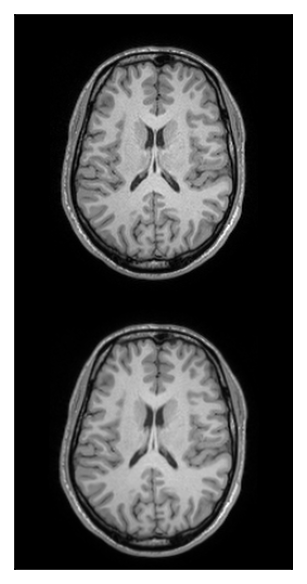

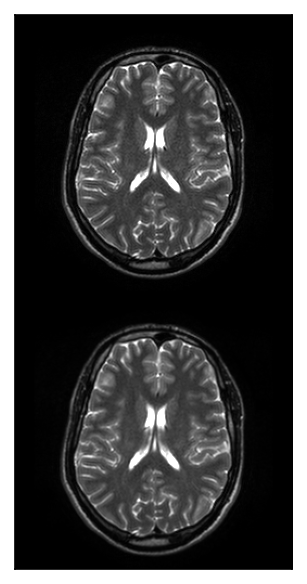

In [18]:
torch.manual_seed(123)
elastic_transform = tio.transforms.RandomElasticDeformation(
    num_control_points=9,  # 제어점의 수 설정
    max_displacement=3,  # 최대 이동 범위 설정 5
)

tmp1 = np.expand_dims(raw_T1, axis=0)
tmp2 = np.expand_dims(raw_T2, axis=0)

# tmp1 = np.expand_dims(Motion_T1_v1, axis=0)
# tmp2 = np.expand_dims(Motion_T2_v1, axis=0)

elastic_T1 = elastic_transform(tmp1).squeeze()
elastic_T2 = elastic_transform(tmp2).squeeze()

zz = 50
show_img(np.concatenate((raw_T1[:,:,zz], elastic_T1[:,:,zz]),0))
show_img(np.concatenate((raw_T2[:,:,zz], elastic_T2[:,:,zz]),0))